# Learning Best Practices for Model Evaluation and Hyperparameter Tuning
In this chapter, the focus is building good model by evaluating performance and fine-tuning the algorithms
The goal is:
  - Assess the performance of machine learning models
  - Dianose the common problems of machine learning algorithms
  - Fine-tune machine learning algorithm
  - Evaluating predictive models using different performance metrics

## Streaming workflows with pipelines
Goal: Learn about `Pipeline` class in scikit-learn

### Loading the Breast Cancer Wisconsin dataset
Breast Cancer Wisconsin dataset, which contains 569 examples of malignant and benign tumor cells. The first two columns in the dataset store the unique ID numbers of the examples and the corresponding diagnoses (M = malignant, B = benign), respectively. Columns 3-32 contain 30 real-valued features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.

In [1]:
# loading data
import pandas as pd
df = pd.read_csv(
 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
 header=None
)

In [2]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
#Encoding label data
from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
#split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

### Combining transfomers and estimators in pipeline

In [5]:
# Standize, reduce dimension and fit data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2),LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acr = pipe_lr.score(X_test, y_test)
print(f'Test acuracy: {test_acr:.3f}')

Test acuracy: 0.956


- Pipeline can be thought of series of functions. In example above, data is passed to `fit` of `pipe_lr`, that go through a series of function  
  - First, it's standardized
  - Second, data is dimensional-reduced using `PCA` with `n_components = 2`
  - Third, and finally it go through LogisticRegression (last element of pipeline also called *estimator*)  

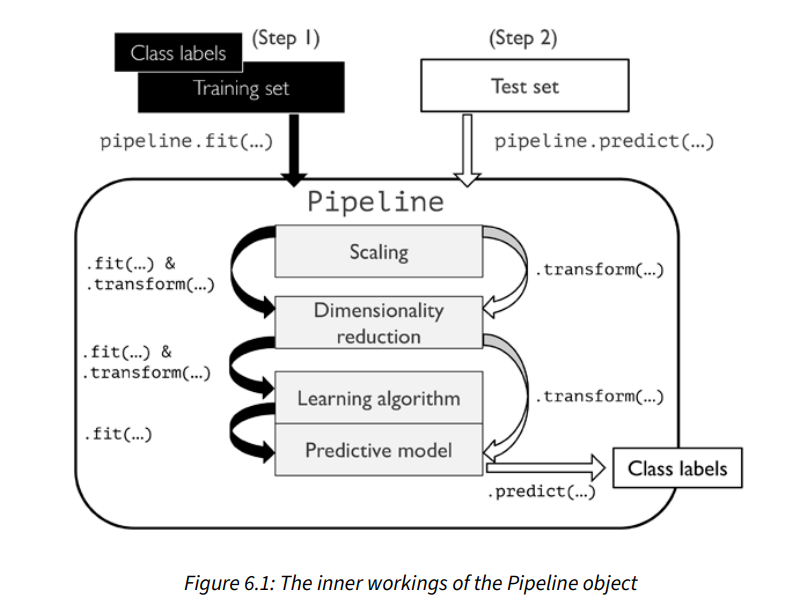
Figure above summarize inner work of pipeline

## Using cross validation to assess performance of model
Just about using **holdout cross-validation** and **k-fold** to evaluate performance of model

### The holdout method
- **First step:** split dataset into 3 parts: train dataset, validation dataset, test dataset
- **Second step:** fit train data using predictive model
- **Third step:** using validation dataset to evaluate performance. choosing the best one
- **Fourth step:** Do test the last time but now using test dataset instead of validation dataset
  
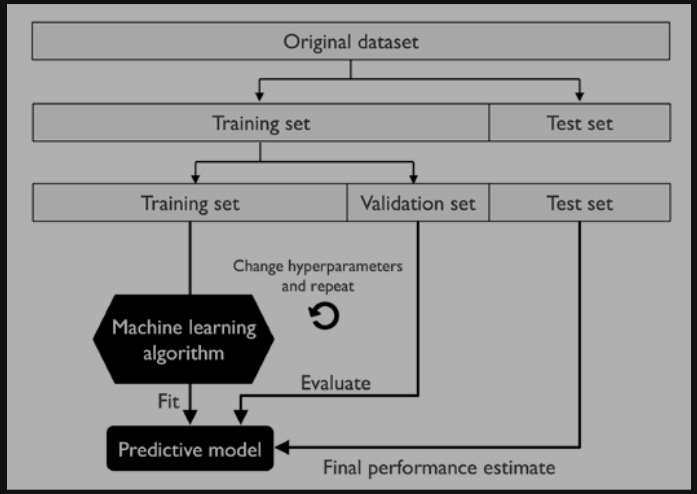

**Note:** A disadvantage of *hold out cross-validation* is that it's very sensitive to how validation dataset chosen. 

### K-fold cross-validation
Just like *hold out cross-validation* but now don't just split it one time and reuse validation dataset.  
    *K-fold cross-validation* splits data into k folds, using k - 1 folds to train data, and left one is used as validation dataset, then evaluate performance by evaluation dataset. Repeat this process k times, averaged test error is less sensitive to how validation dataset now.  
    A slightly better *K-fold* is **stratified k-fold*, which still divides k folds but know the validation one preserves the proportion of label classes to make sure it's **representative**.

In [6]:
# Stratified k folds
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 10).split(X_train,y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])}, '
          f'Acc.: {score:.3f}')


Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956


In [7]:
#k-fold scorer
from sklearn.model_selection import cross_val_score
scores =  cross_val_score(estimator = pipe_lr, X=X_train,y=y_train,cv = 10, n_jobs=1)
print(scores)

[0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


## Debugging algorithms with learning and validation curves
**Goal:**
- Using methods (learning curves and validation curves) to diagnose the problem (overfitting or underfitting)

### Diagnosing bias and variance problems with learning curves

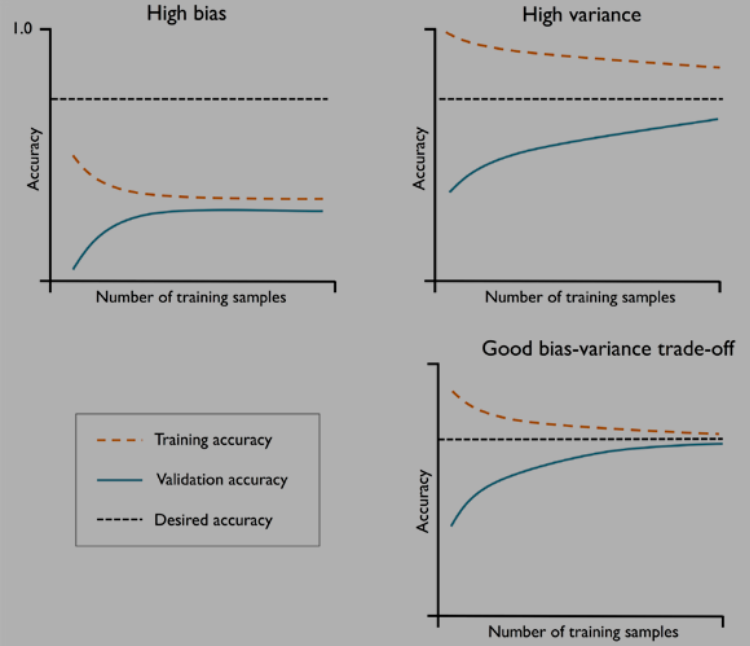

- If a model has high bias, low training, validation accuracy (like upper left one) then we can increase number of parameters, relax degree of regulation.
- If a model has high variance, and overfitting (like upper right one) due to large gap between training accuracy and test accuracy then we can collect more data points, reduce complexity of model, increase regulation

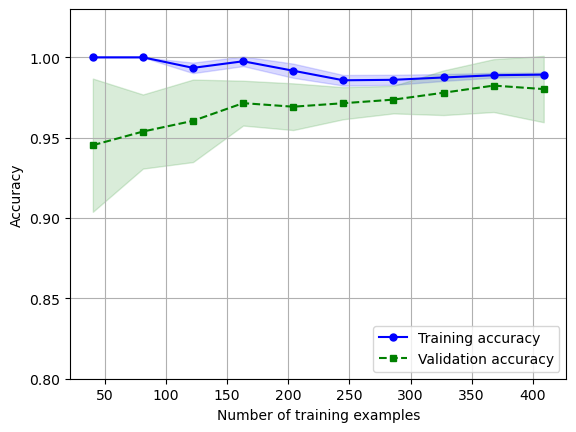

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Assuming X_train and y_train are already defined
pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', max_iter=10000)
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std,
                 test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()


`learning curve` takes parameters:
- `estimator` can take a pipeline or just some model
- `X`, `y` take training dataset
- `train_sizes` takes the proportion of size of train data for each validation
- `cv` takes the # fold, it will splits (stratified fold)

### Addressing over- and underfitting with validation curves
Like `learning_curve`, `validation` plot the *training accuracy* and *validation accuracy* but it varies parameter of model

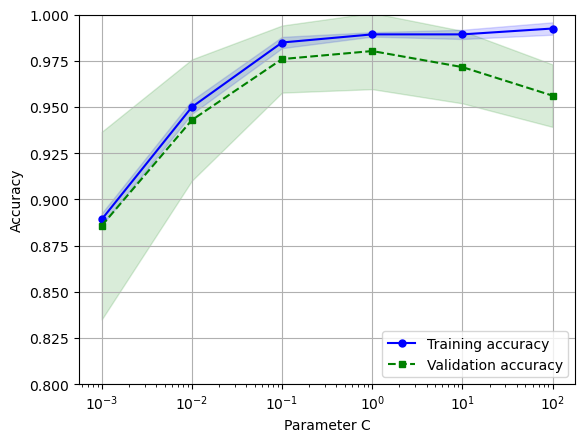

In [13]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()


## Fine-tuning machine learning models via grid search 
There are 2 types of parameters, those learn from train dataset like weights in logistic regression model, those are seperately chosen. The latter one is called tuning parameters (or hyperparameter). **Grid search** is technique intended to find the combinations of hyperparameter that's optimized for model.

### Tuning hyperparameters via grid search
It's a brute-force exhaustive search paradigm, we feed it a list of parameters, then i will search for all combinations to find the best one.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)


0.9846859903381642


In [18]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In code above:
- `GridSearchCV` takes:
  - `estimator`: pass model want to fine-tuning
  -  `param_digm`: takes parameters you want to fine-tune
  -  `cv`: # of folds
  -  `scoring`: pass criterion in which computer will rank combinations of parameter (here *'accuracy'* is the criterion)
- `best_score_` *attribute* is used to access score of best model obtain
- `best_params_` *attribute* is used to access the best combs of model
- `best_estimator_` *attribute* returned the best model

In [20]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test)}')

Test accuracy: 0.9736842105263158


### Exploring hyperparameter configurations more widely with randomized search
This algorithm uses distribution to choose combinations of parameters instead of specifying range in Grid Search

In [21]:
param_range = [
    0.0001, 0.001, 0.01, 0.1,
    1.0, 10.0, 100.0, 1000.0
]


In [22]:
import scipy.stats

param_range = scipy.stats.loguniform(0.0001, 1000.0)


In [23]:
np.random.seed(1)
param_range = scipy.stats.loguniform(0.0001, 1000.0)
samples = param_range.rvs(10)
print(samples)

[8.30145146e-02 1.10222804e+01 1.00184520e-04 1.30715777e-02
 1.06485687e-03 4.42965766e-04 2.01289666e-03 2.62376594e-02
 5.98924832e-02 5.91176467e-01]


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np
import scipy.stats

# Prepare data and distribution
np.random.seed(1)
param_range = scipy.stats.loguniform(0.0001, 1000.0)

# Pipeline setup
pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1)
)

# Parameter grid for randomized search
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]

# Randomized search
rs = RandomizedSearchCV(
    estimator=pipe_svc,
    param_distributions=param_grid,
    scoring='accuracy',
    refit=True,
    n_iter=20,
    cv=10,
    random_state=1,
    n_jobs=-1
)

# Fit and print results
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)


0.9780676328502416
{'svc__C': np.float64(0.05971247755848463), 'svc__kernel': 'linear'}


### More resource-efficient hyperparameter search with successive halving
It works by 
- choosing a set of combinations
- Test that one setting with small subset of train dataset
- Get rid of bottom $\mathbf{50}$% of the setting.
- Go back to step 2 with increased amount of available resources

In [28]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
hs = HalvingRandomSearchCV(pipe_svc,
                           param_distributions = param_grid,
                           n_candidates = 'exhaust',
                           resource = 'n_samples',
                           factor = 1.5,
                           random_state = 1,
                           n_jobs = None)

In the code above:
- `n_candidates` is the initial number randomly sampled hyperparameter combinations.
- `resources` is how training dataset is increased. `'exhause'` means last time it evaluates training dataset is the whole train dataset
- `factor` decides how many of those will be passed to next round (1.5 mean (100/1.5)% will make it into next round

In [33]:
hs = hs.fit(X_train, y_train)
clf = hs.best_estimator_
print(f'Accuracy: {clf.score(X_test, y_test)}')

Accuracy: 0.9824561403508771


### Algorithm selection with nested cross-validation
It just applies **hold out method** for each *'cross'*

In [34]:
from sklearn.model_selection import GridSearchCV, cross_val_score

param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2) # 2 inner loops are here

scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5) # 5 outer loops are here

print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')


CV accuracy: 0.974 +/- 0.015


## Looking at different performance evaluation metrics
There's are other metrics to evaluate model rather than just *'accuracy'*

### Reading a confusion matrix
**Confusion matrix** is matrix whose entries report number of (true positive, false negative, false positive, true negative)

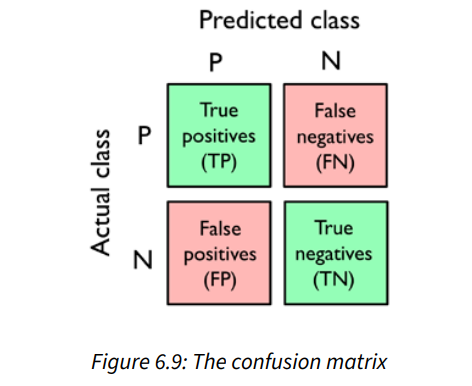

In [36]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred) #confusion matrix
print(confmat)

[[71  1]
 [ 2 40]]


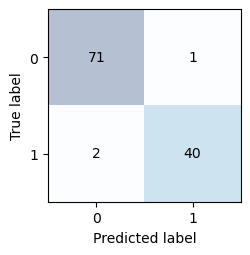

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


### Optimizing the precision and recall of a classification model
- **True Positive Rate** and **False Positive Rate** are defined by formula:
$$TPR = \frac{TP}{P} = \frac{TP}{TP + FN}$$
$$FPR = \frac{FP}{P} = \frac{FP}{FP + TN}$$
- **recall (REC)** is performance metrics is defined as follow:
$$REC = TPR = \frac{TP}{P} = \frac{TP}{TP + FN}$$
- **precision (PRE)** is performance metrics is defined as follow:
$$PRE = \frac{TP}{TP + FP}$$
- **F1** is the balance between PRE and REC, it is harmonic mean of PRE and REC:
$$F1 = 2\frac{PRE \times REC}{PRE + REC}$$
- MCC is another metric ranges from -1 to 1, it takes all element of confusion matrix into account, harder to intepret, and especially popular in biological research
$$MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$$


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

# Calculate metrics
precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred)
mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)

# Print results
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'Matthews Correlation Coefficient (MCC): {mcc:.3f}')


Precision: 0.976
Recall: 0.952
F1 Score: 0.964
Matthews Correlation Coefficient (MCC): 0.943
